Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Tune LightGBM with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of LightGBM with a regression example.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Regression Example
### Load data and preprocess

Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=537, data_dir='./')

load dataset from ./openml_ds537.pkl
Dataset name: houses
X_train.shape: (15480, 8), y_train.shape: (15480,);
X_test.shape: (5160, 8), y_test.shape: (5160,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 150,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment.log',  # flaml log file
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 07-24 13:49:03] {912} INFO - Evaluation method: cv
[flaml.automl: 07-24 13:49:03] {616} INFO - Using RepeatedKFold
[flaml.automl: 07-24 13:49:03] {933} INFO - Minimizing error metric: 1-r2
[flaml.automl: 07-24 13:49:03] {952} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 07-24 13:49:03] {1018} INFO - iteration 0, current learner lgbm
[flaml.automl: 07-24 13:49:03] {1173} INFO -  at 0.5s,	best lgbm's error=0.7385,	best lgbm's error=0.7385
[flaml.automl: 07-24 13:49:03] {1018} INFO - iteration 1, current learner lgbm
[flaml.automl: 07-24 13:49:03] {1173} INFO -  at 0.7s,	best lgbm's error=0.7385,	best lgbm's error=0.7385
[flaml.automl: 07-24 13:49:03] {1018} INFO - iteration 2, current learner lgbm
[flaml.automl: 07-24 13:49:03] {1173} INFO -  at 0.9s,	best lgbm's error=0.5520,	best lgbm's error=0.5520
[flaml.automl: 07-24 13:49:03] {1018} INFO - iteration 3, current learner lgbm
[flaml.automl: 07-24 13:49:04] {1173} INFO -  at 1.1s,	best lgbm's error=0

### Best model and metric

In [5]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 157, 'num_leaves': 4886, 'min_child_samples': 64, 'learning_rate': 0.08917691724022275, 'subsample': 0.8278302514488655, 'log_max_bin': 9, 'colsample_bytree': 0.788228718184241, 'reg_alpha': 0.042293060180467086, 'reg_lambda': 95.16149755350158}
Best r2 on validation data: 0.8389
Training duration of best run: 4.971 s


In [6]:
automl.model.estimator

LGBMRegressor(colsample_bytree=0.788228718184241,
              learning_rate=0.08917691724022275, max_bin=256,
              min_child_samples=64, n_estimators=157, num_leaves=4886,
              objective='regression', reg_alpha=0.042293060180467086,
              reg_lambda=95.16149755350158, subsample=0.8278302514488655)

In [7]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [8]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels [143563.86395674 254576.18760499 144158.79619969 ... 196049.43993507
 252324.54317706 279607.98371458]
True labels 14740    136900.0
10101    241300.0
20566    200700.0
2670      72500.0
15709    460000.0
           ...   
13132    121200.0
8228     137500.0
3948     160900.0
8522     227300.0
16798    265600.0
Name: median_house_value, Length: 5160, dtype: float64


In [9]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

r2 = 0.8467624164909245
mse = 2025572000.0048184
mae = 29845.819846911687


In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.25912534572860507, 'subsample': 0.9266743941610592, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0013933617380144255, 'reg_lambda': 0.18096917948292954}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.25912534572860507, 'subsam

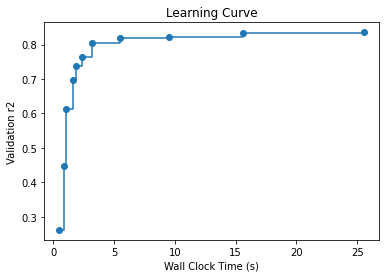

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives

### FLAML's accuracy

In [12]:
print('flaml r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

flaml r2 = 0.8467624164909245


### Default LightGBM

In [13]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()

In [14]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [15]:
y_pred = lgbm.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default lgbm r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

default lgbm r2 = 0.8296179648694404


### Optuna LightGBM Tuner

In [16]:
# !pip install optuna==2.8.0;

In [17]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
import optuna.integration.lightgbm as lgb
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)
params = {
    "objective": "regression",
    "metric": "regression",
    "verbosity": -1,
}


In [18]:
%%time
model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], verbose_eval=10000)        


[I 2021-07-24 13:51:37,223] A new study created in memory with name: no-name-a9ad03a9-1a95-4cb8-903f-402d3a214640
bagging, val_score: 2193757572.841483: 100%|##########| 10/10 [00:23<00:00,  2.31s/it]
feature_fraction_stage2, val_score: 2193757572.841483:  17%|#6        | 1/6 [00:01<00:08,  1.68s/it][I 2021-07-24 13:53:45,444] Trial 37 finished with value: 2193757572.841483 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 2193757572.841483.
feature_fraction_stage2, val_score: 2193757572.841483:  33%|###3      | 2/6 [00:03<00:06,  1.68s/it][I 2021-07-24 13:53:47,130] Trial 38 finished with value: 2193757572.841483 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 2193757572.841483.
feature_fraction_stage2, val_score: 2193757572.841483:  50%|#####     | 3/6 [00:05<00:05,  1.68s/it][I 2021-07-24 13:53:48,802] Trial 39 finished with value: 2193757572.841483 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value:

CPU times: user 2min 55s, sys: 8.33 s, total: 3min 3s
Wall time: 3min 4s


In [19]:
y_pred = model.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('Optuna LightGBM Tuner r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

Optuna LightGBM Tuner r2 = 0.8454106958774709


## 4. Add a customized LightGBM learner in FLAML
The native API of LightGBM allows one to specify a custom objective function in the model constructor. You can easily enable it by adding a customized LightGBM learner in FLAML. In the following example, we show how to add such a customized LightGBM learner with a custom objective function.

### Create a customized LightGBM learner with a custom objective function

In [20]:

import numpy as np 

''' define your customized objective function '''
def my_loss_obj(y_true, y_pred):
    c = 0.5
    residual = y_pred - y_true
    grad = c * residual /(np.abs(residual) + c)
    hess = c ** 2 / (np.abs(residual) + c) ** 2
    # rmse grad and hess
    grad_rmse = residual
    hess_rmse = 1.0
    
    # mae grad and hess
    grad_mae = np.array(residual)
    grad_mae[grad_mae > 0] = 1.
    grad_mae[grad_mae <= 0] = -1.
    hess_mae = 1.0

    coef = [0.4, 0.3, 0.3]
    return coef[0] * grad + coef[1] * grad_rmse + coef[2] * grad_mae, \
        coef[0] * hess + coef[1] * hess_rmse + coef[2] * hess_mae


from flaml.model import LGBMEstimator

''' create a customized LightGBM learner class with your objective function '''
class MyLGBM(LGBMEstimator):
    '''LGBMEstimator with my_loss_obj as the objective function
    '''

    def __init__(self, **params):
        super().__init__(objective=my_loss_obj, **params)

### Add the customized learner in FLAML

In [21]:
automl = AutoML()
automl.add_learner(learner_name='my_lgbm', learner_class=MyLGBM)
settings = {
    "time_budget": 150,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['my_lgbm',],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment_my_lgbm.log',  # flaml log file
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 07-24 13:54:42] {912} INFO - Evaluation method: cv
[flaml.automl: 07-24 13:54:42] {616} INFO - Using RepeatedKFold
[flaml.automl: 07-24 13:54:42] {933} INFO - Minimizing error metric: 1-r2
[flaml.automl: 07-24 13:54:42] {952} INFO - List of ML learners in AutoML Run: ['my_lgbm']
[flaml.automl: 07-24 13:54:42] {1018} INFO - iteration 0, current learner my_lgbm
[flaml.automl: 07-24 13:54:42] {1173} INFO -  at 0.3s,	best my_lgbm's error=2.9888,	best my_lgbm's error=2.9888
[flaml.automl: 07-24 13:54:42] {1018} INFO - iteration 1, current learner my_lgbm
[flaml.automl: 07-24 13:54:42] {1173} INFO -  at 0.4s,	best my_lgbm's error=2.9888,	best my_lgbm's error=2.9888
[flaml.automl: 07-24 13:54:42] {1018} INFO - iteration 2, current learner my_lgbm
[flaml.automl: 07-24 13:54:42] {1173} INFO -  at 0.6s,	best my_lgbm's error=1.7536,	best my_lgbm's error=1.7536
[flaml.automl: 07-24 13:54:42] {1018} INFO - iteration 3, current learner my_lgbm
[flaml.automl: 07-24 13:54:42] {1173} INF

In [22]:
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

Best hyperparmeter config: {'n_estimators': 754, 'num_leaves': 710, 'min_child_samples': 128, 'learning_rate': 0.10575205975801834, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 0.7929174747127123, 'reg_alpha': 0.0009765625, 'reg_lambda': 10.762106709995438}
Best r2 on validation data: 0.8376
Training duration of best run: 13.28 s
Predicted labels [135768.25690639 246689.39399877 136637.13857269 ... 175212.47378055
 243756.5990978  271017.12074672]
True labels 14740    136900.0
10101    241300.0
20566    200700.0
2670      72500.0
15709    460000.0
           ...   
13132    121200.0
8228     137500.0
3948     160900.0
8522     227300.0
16798    265600.0
Name: median_house_value, Length: 5160, dtype: float64
r2 = 0.8459538207127344
mse = 2036260428.588182
mae = 30277.65301151835
